In [1]:
!pip install transformers datasets scikit-learn tqdm matplotlib seaborn --quiet
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Running on {device}")


✅ Running on cpu


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


C:\Users\AS\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = load_dataset('glue', 'mrpc')


In [4]:
# 4. Tokenize Sentences
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def tokenize_function(example):
    return tokenizer(example['sentence1'], example['sentence2'], truncation=True, padding='max_length', max_length=128)

encoded_dataset = dataset.map(tokenize_function, batched=True)
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


C:\Users\AS\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\AS\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Map: 100%|████████████████████████| 1725/1725 [00:00<00:00, 4515.96 examples/s]


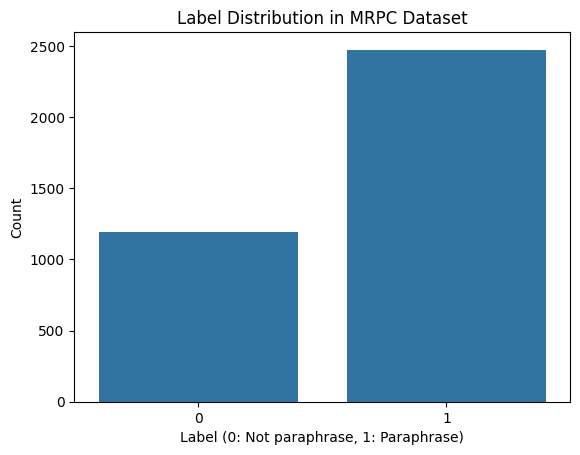

In [5]:
# 5. Visualize Label Distribution
labels = dataset['train']['label']
sns.countplot(x=labels)
plt.title("Label Distribution in MRPC Dataset")
plt.xlabel("Label (0: Not paraphrase, 1: Paraphrase)")
plt.ylabel("Count")
plt.show()


In [6]:
# 6. Load RoBERTa-base Model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [8]:
# 6. Set Training Arguments
training_args = TrainingArguments(
    output_dir='./outputs/checkpoints',
    # evaluation_strategy="epoch",  # Removed in transformers 4.51.3
    # save_strategy="epoch",  # Removed in transformers 4.51.3
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./outputs/logs',
    logging_steps=10, # Control evaluation frequency indirectly with logging_steps or save_steps
      report_to="none" ,
    # load_best_model_at_end=True,  # Removed in transformers 4.51.3
    # metric_for_best_model='eval_loss'  # Removed in transformers 4.51.3
)

In [9]:
# 8. Define Evaluation Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'macro_f1': f1
    }


In [10]:
# 9. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    compute_metrics=compute_metrics,
)


In [11]:
# 10. Fine-tune RoBERTa on MRPC
trainer.train()


Step,Training Loss
10,0.676300
20,0.647000
30,0.636500
40,0.571500
50,0.519700
60,0.482800
70,0.470600
80,0.476400
90,0.489600
100,0.438200


TrainOutput(global_step=230, training_loss=0.43003089324287747, metrics={'train_runtime': 5623.3073, 'train_samples_per_second': 1.305, 'train_steps_per_second': 0.041, 'total_flos': 482545675530240.0, 'train_loss': 0.43003089324287747, 'epoch': 2.0})

In [12]:
# 11. Evaluate Fine-tuned RoBERTa
eval_results = trainer.evaluate()

print(f"✅ Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"✅ Precision: {eval_results['eval_precision']:.4f}")
print(f"✅ Recall: {eval_results['eval_recall']:.4f}")
print(f"✅ Macro F1 Score: {eval_results['eval_macro_f1']:.4f}")


✅ Accuracy: 0.8676
✅ Precision: 0.8550
✅ Recall: 0.8324
✅ Macro F1 Score: 0.8421


In [13]:
trainer.save_model('./outputs_roberta/fine_tuned_roberta_mrpc')
tokenizer.save_pretrained('./outputs_roberta/fine_tuned_roberta_mrpc')


('./outputs_roberta/fine_tuned_roberta_mrpc\\tokenizer_config.json',
 './outputs_roberta/fine_tuned_roberta_mrpc\\special_tokens_map.json',
 './outputs_roberta/fine_tuned_roberta_mrpc\\vocab.json',
 './outputs_roberta/fine_tuned_roberta_mrpc\\merges.txt',
 './outputs_roberta/fine_tuned_roberta_mrpc\\added_tokens.json',
 './outputs_roberta/fine_tuned_roberta_mrpc\\tokenizer.json')